# CS 6476 Computer Vision: VIVIT Lie Detector Project

In [ ]:
!pip -q install einops
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
if os.getcwd() != '/content/drive/My Drive/ViViT_Lie_Detector':
  os.chdir('drive/MyDrive/ViViT_Lie_Detector')
print(os.getcwd())

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1xxsKFSosYh1kYovEZDtJbc9ixw7K0rfR/ViViT_Lie_Detector


In [ ]:
import torch
from torch import nn, einsum
import torch.nn.functional as F
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from module import Attention, PreNorm, FeedForward
import numpy as np
from math import ceil
import argparse
from CONSTANTS import BATCH_SIZE, PATCH_SIZE, IMG_SIZE, FRAME_NUM
import zipfile
from tqdm import tqdm
import io
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from vivit import ViViT, Transformer
from Trainer import VIVIT_Trainer
import matplotlib.pyplot as plt
import cv2

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'using {device} device...')

using cuda device...


In [ ]:
os.listdir()

['RealLifeDeceptionDetection.2016.zip',
 'MU3D_dataset.zip',
 'Processing_results',
 'Frame_selection_using _FAU.py',
 '__pycache__',
 'FAU_detection.png',
 'CONSTANTS.py',
 'module.py',
 'emotion_detection',
 'vivit.ipynb',
 'train.py',
 'All_unique_peaks.png',
 'Per_FAU_unique_peaks.png',
 'Trainer.py',
 'Improving key frame sampling through facial action unit tracking.docx',
 'vivit.py',
 'fully_trained_model.pth',
 'Inference.py',
 'vivit_FK.ipynb']

### Loading Processed Dataset

In [ ]:
# Labels
label_archive = zipfile.ZipFile('MU3D_dataset.zip', 'r')
for file in tqdm(label_archive.infolist()):
  if file.filename.endswith('.xlsx'):
    with label_archive.open(file) as label_file:
      label = pd.read_excel(label_file, sheet_name='Video-Level Data')
      # display(label.head(3))

y = torch.tensor(label['Veracity'].astype('float').values)
y = y[:]
y = y.unsqueeze(1)
print(y.shape)

100%|██████████| 5/5 [00:01<00:00,  4.92it/s]

torch.Size([320, 1])


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Assuming img_dataset is some dataset you have created and y contains labels

class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

# Custom collate function to pad sequences to the same length
def custom_collate_fn(batch):
    images, labels = zip(*batch)

    # Get the maximum number of frames (sequences) among images in the batch
    #max_frames = max(img.shape[0] for img in images)

    # Pad sequences to the maximum length within the batch
    padded_images = []
    for img in images:
        img_tensor = torch.tensor(img)
        #print(img_tensor.shape)
        desired_frames = 120
        padding_frames = desired_frames - img_tensor.shape[0]
        padding_tensor = torch.zeros(padding_frames, img_tensor.shape[1], img_tensor.shape[2], img_tensor.shape[3])
        # Concatenate the original tensor and the padding tensor along the frames dimension
        padded_img = torch.cat([img_tensor, padding_tensor], dim=0)
        #print(padded_img.shape)
        padded_images.append(padded_img.unsqueeze(0))  # Add batch dimension
    padded_images = torch.cat(padded_images, dim=0)  # Concatenate padded images along batch dimension

    return padded_images, torch.tensor(labels)

def get_max_frame(img_dataset):
  max_frame = 0
  for img_seq in img_dataset:
    num_seq = np.shape(img_seq)[0]
    max_frame = max(max_frame, num_seq)
  print(max_frame)
  return max_frame


In [ ]:
# Now, iterate through the DataLoader in your training loop
import gc

''' _old/stack for midterm/final '''
img_archive = zipfile.ZipFile('Processing_results/resized_image_stack.zip', 'r')
#img_archive = zipfile.ZipFile('Processing_results/filtered_image_stack_old.zip', 'r')
# ViViT model
H = 480
W =880
FRAME_NUM = 120
model = ViViT(image_size_w=W, image_size_h=H,
                  patch_size_w=110, patch_size_h=60,
                    num_classes=1,
                    num_frames=FRAME_NUM, pool='cls').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-6)
criterion = nn.BCELoss()

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"
# Define batch size
batch_size = 12  # You can adjust this according to your memory constraints
batch_number =int( y.shape[0]/batch_size)
for i in range(batch_number-1):
  img_dataset = []
  for file in tqdm(img_archive.infolist()[i*3*batch_size:(i+1)*3*batch_size]):
    if file.filename.endswith('.npy'):
      with img_archive.open(file) as npy_file:
        img = np.load(io.BytesIO(npy_file.read()))
        #if img.shape[1] == w and img.shape[2] == h and img.shape[3] == c:
        img_dataset.append(img)
  print(len(img_dataset))
  label = y[i*batch_size:(i+1)*batch_size]
  # Create a CustomDataset instance
  custom_dataset = CustomDataset(img_dataset, label)

  # Define batch size
  #batch_size = 8  # You can adjust this according to your memory constraints

  #max_frame = get_max_frame(img_dataset)

  # Create a DataLoader with custom collate function
  train_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

  for imageset, labels in train_loader:
    img_tensors = []
    for img in tqdm(imageset):
      img_tensors.append(torch.tensor(img))
    #img_tensors = [torch.tensor(img) for img in images]
    train_dataloader = torch.nn.utils.rnn.pad_sequence(img_tensors, batch_first=True)
    print(train_dataloader.shape)  # (batch_size, frames, height, width, channel)
    N, T, H, W, C = train_dataloader.shape

    # Permute dimensions for correct shaping
    train_dataloader = train_dataloader.permute(0, 1, 4, 2, 3)  # correct shaping
    print(train_dataloader.shape)

    # training and testing splt
    X_train, X_test, y_train, y_test = train_test_split(train_dataloader, labels, test_size=0.3, random_state=42)

    Trainer = VIVIT_Trainer(model, optimizer, criterion)
    Trainer.train(X_train, X_test, y_train, y_test, BATCH_SIZE=8, num_epoch=1)
    del imageset, labels
    gc.collect()



100%|██████████| 36/36 [00:07<00:00,  4.93it/s]


12


  0%|          | 0/12 [00:00<?, ?it/s]<ipython-input-10-e6ac3445f564>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_tensors.append(torch.tensor(img))
100%|██████████| 12/12 [00:00<00:00, 19.35it/s]


torch.Size([12, 120, 480, 880, 3])
torch.Size([12, 120, 3, 480, 880])
using cuda device...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.6619075536727905
Epoch 1, Training Loss: 0.6619075536727905, Test Loss: 0.7730893492698669, Accuracy: 1.0


100%|██████████| 1/1 [01:21<00:00, 81.73s/it]


Better validation accuracy, model saved successfully!


100%|██████████| 36/36 [00:06<00:00,  5.28it/s]


12


100%|██████████| 12/12 [00:00<00:00, 12.43it/s]


torch.Size([12, 120, 480, 880, 3])
torch.Size([12, 120, 3, 480, 880])
using cuda device...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.6288807988166809


100%|██████████| 1/1 [00:20<00:00, 20.42s/it]


Epoch 1, Training Loss: 0.6288807988166809, Test Loss: 1.0373401641845703, Accuracy: 0.0


100%|██████████| 36/36 [00:07<00:00,  5.09it/s]


12


100%|██████████| 12/12 [00:00<00:00, 13.14it/s]


torch.Size([12, 120, 480, 880, 3])
torch.Size([12, 120, 3, 480, 880])
using cuda device...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.5880545973777771


100%|██████████| 1/1 [00:19<00:00, 19.74s/it]


Epoch 1, Training Loss: 0.5880545973777771, Test Loss: 1.3191472291946411, Accuracy: 0.0


100%|██████████| 36/36 [00:07<00:00,  5.05it/s]


12


100%|██████████| 12/12 [00:00<00:00, 13.18it/s]


torch.Size([12, 120, 480, 880, 3])
torch.Size([12, 120, 3, 480, 880])
using cuda device...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.9378677606582642
Epoch 1, Training Loss: 0.9378677606582642, Test Loss: 0.5632367134094238, Accuracy: 3.0


100%|██████████| 1/1 [00:27<00:00, 27.98s/it]


Better validation accuracy, model saved successfully!


100%|██████████| 36/36 [00:07<00:00,  4.50it/s]


12


100%|██████████| 12/12 [00:00<00:00, 13.22it/s]


torch.Size([12, 120, 480, 880, 3])
torch.Size([12, 120, 3, 480, 880])
using cuda device...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.8020867705345154
Epoch 1, Training Loss: 0.8020867705345154, Test Loss: 0.7936261296272278, Accuracy: 2.0


100%|██████████| 1/1 [00:28<00:00, 28.35s/it]


Better validation accuracy, model saved successfully!


100%|██████████| 36/36 [00:06<00:00,  5.20it/s]


12


100%|██████████| 12/12 [00:00<00:00, 12.71it/s]


torch.Size([12, 120, 480, 880, 3])
torch.Size([12, 120, 3, 480, 880])
using cuda device...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.6748865842819214
Epoch 1, Training Loss: 0.6748865842819214, Test Loss: 0.9240620732307434, Accuracy: 1.0


100%|██████████| 1/1 [00:32<00:00, 32.56s/it]


Better validation accuracy, model saved successfully!


100%|██████████| 36/36 [00:08<00:00,  4.35it/s]


12


100%|██████████| 12/12 [00:00<00:00, 12.65it/s]


torch.Size([12, 120, 480, 880, 3])
torch.Size([12, 120, 3, 480, 880])
using cuda device...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.744914174079895
Epoch 1, Training Loss: 0.744914174079895, Test Loss: 0.7178341150283813, Accuracy: 2.0


100%|██████████| 1/1 [00:28<00:00, 28.19s/it]


Better validation accuracy, model saved successfully!


100%|██████████| 36/36 [00:08<00:00,  4.24it/s]


12


100%|██████████| 12/12 [00:00<00:00, 12.27it/s]


torch.Size([12, 120, 480, 880, 3])
torch.Size([12, 120, 3, 480, 880])
using cuda device...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.7169977426528931
Epoch 1, Training Loss: 0.7169977426528931, Test Loss: 0.7125381827354431, Accuracy: 2.0


100%|██████████| 1/1 [00:27<00:00, 27.77s/it]


Better validation accuracy, model saved successfully!


100%|██████████| 36/36 [00:09<00:00,  3.91it/s]


12


100%|██████████| 12/12 [00:00<00:00, 12.20it/s]


torch.Size([12, 120, 480, 880, 3])
torch.Size([12, 120, 3, 480, 880])
using cuda device...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.7421796321868896
Epoch 1, Training Loss: 0.7421796321868896, Test Loss: 0.6629130244255066, Accuracy: 3.0


100%|██████████| 1/1 [00:32<00:00, 32.53s/it]


Better validation accuracy, model saved successfully!


100%|██████████| 36/36 [00:10<00:00,  3.57it/s]


12


100%|██████████| 12/12 [00:00<00:00, 12.73it/s]


torch.Size([12, 120, 480, 880, 3])
torch.Size([12, 120, 3, 480, 880])
using cuda device...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.7221991419792175
Epoch 1, Training Loss: 0.7221991419792175, Test Loss: 0.7096173763275146, Accuracy: 1.5


100%|██████████| 1/1 [00:32<00:00, 32.37s/it]


Better validation accuracy, model saved successfully!


100%|██████████| 36/36 [00:07<00:00,  4.52it/s]


12


100%|██████████| 12/12 [00:00<00:00, 12.17it/s]


torch.Size([12, 120, 480, 880, 3])
torch.Size([12, 120, 3, 480, 880])
using cuda device...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.6837531328201294
Epoch 1, Training Loss: 0.6837531328201294, Test Loss: 0.8020370602607727, Accuracy: 1.0


100%|██████████| 1/1 [00:32<00:00, 32.74s/it]


Better validation accuracy, model saved successfully!


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]


12


100%|██████████| 12/12 [00:00<00:00, 12.32it/s]


torch.Size([12, 120, 480, 880, 3])
torch.Size([12, 120, 3, 480, 880])
using cuda device...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.6770291328430176
Epoch 1, Training Loss: 0.6770291328430176, Test Loss: 0.8421969413757324, Accuracy: 1.0


100%|██████████| 1/1 [00:29<00:00, 29.36s/it]


Better validation accuracy, model saved successfully!


100%|██████████| 36/36 [00:07<00:00,  4.91it/s]


12


100%|██████████| 12/12 [00:00<00:00, 12.54it/s]


torch.Size([12, 120, 480, 880, 3])
torch.Size([12, 120, 3, 480, 880])
using cuda device...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.6939648985862732
Epoch 1, Training Loss: 0.6939648985862732, Test Loss: 0.7459509372711182, Accuracy: 2.0


100%|██████████| 1/1 [00:28<00:00, 28.83s/it]


Better validation accuracy, model saved successfully!


100%|██████████| 36/36 [00:07<00:00,  4.82it/s]


12


100%|██████████| 12/12 [00:00<00:00, 12.19it/s]


torch.Size([12, 120, 480, 880, 3])
torch.Size([12, 120, 3, 480, 880])
using cuda device...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.7431936264038086
Epoch 1, Training Loss: 0.7431936264038086, Test Loss: 0.765975832939148, Accuracy: 2.0


100%|██████████| 1/1 [00:28<00:00, 28.12s/it]


Better validation accuracy, model saved successfully!


100%|██████████| 36/36 [00:07<00:00,  4.84it/s]


12


100%|██████████| 12/12 [00:01<00:00, 11.86it/s]


torch.Size([12, 120, 480, 880, 3])
torch.Size([12, 120, 3, 480, 880])
using cuda device...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.7379868030548096
Epoch 1, Training Loss: 0.7379868030548096, Test Loss: 0.7667180299758911, Accuracy: 2.0


100%|██████████| 1/1 [00:29<00:00, 29.33s/it]


Better validation accuracy, model saved successfully!


100%|██████████| 36/36 [00:07<00:00,  4.89it/s]


12


100%|██████████| 12/12 [00:01<00:00, 10.96it/s]


torch.Size([12, 120, 480, 880, 3])
torch.Size([12, 120, 3, 480, 880])
using cuda device...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.7672778367996216
Epoch 1, Training Loss: 0.7672778367996216, Test Loss: 0.7546137571334839, Accuracy: 2.0


100%|██████████| 1/1 [00:28<00:00, 28.65s/it]


Better validation accuracy, model saved successfully!


100%|██████████| 36/36 [00:07<00:00,  4.88it/s]


12


100%|██████████| 12/12 [00:00<00:00, 13.15it/s]


torch.Size([12, 120, 480, 880, 3])
torch.Size([12, 120, 3, 480, 880])
using cuda device...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.8538533449172974
Epoch 1, Training Loss: 0.8538533449172974, Test Loss: 0.5790554881095886, Accuracy: 3.0


100%|██████████| 1/1 [00:31<00:00, 31.84s/it]


Better validation accuracy, model saved successfully!


100%|██████████| 36/36 [00:07<00:00,  5.14it/s]


12


100%|██████████| 12/12 [00:01<00:00, 10.71it/s]


torch.Size([12, 120, 480, 880, 3])
torch.Size([12, 120, 3, 480, 880])
using cuda device...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.6575525999069214
Epoch 1, Training Loss: 0.6575525999069214, Test Loss: 0.8591617345809937, Accuracy: 1.0


100%|██████████| 1/1 [00:29<00:00, 29.41s/it]


Better validation accuracy, model saved successfully!


100%|██████████| 36/36 [00:07<00:00,  4.83it/s]


12


100%|██████████| 12/12 [00:01<00:00, 10.75it/s]


torch.Size([12, 120, 480, 880, 3])
torch.Size([12, 120, 3, 480, 880])
using cuda device...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.7251242995262146
Epoch 1, Training Loss: 0.7251242995262146, Test Loss: 0.7201528549194336, Accuracy: 2.0


100%|██████████| 1/1 [00:33<00:00, 33.21s/it]


Better validation accuracy, model saved successfully!


100%|██████████| 36/36 [00:07<00:00,  4.83it/s]


12


100%|██████████| 12/12 [00:01<00:00,  9.93it/s]


torch.Size([12, 120, 480, 880, 3])
torch.Size([12, 120, 3, 480, 880])
using cuda device...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.7751936912536621
Epoch 1, Training Loss: 0.7751936912536621, Test Loss: 0.6233468055725098, Accuracy: 3.0


100%|██████████| 1/1 [00:30<00:00, 30.04s/it]


Better validation accuracy, model saved successfully!


100%|██████████| 36/36 [00:08<00:00,  4.34it/s]


12


100%|██████████| 12/12 [00:01<00:00, 11.37it/s]


torch.Size([12, 120, 480, 880, 3])
torch.Size([12, 120, 3, 480, 880])
using cuda device...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.7482304573059082
Epoch 1, Training Loss: 0.7482304573059082, Test Loss: 0.6458948850631714, Accuracy: 3.0


100%|██████████| 1/1 [00:29<00:00, 30.00s/it]


Better validation accuracy, model saved successfully!


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


12


100%|██████████| 12/12 [00:01<00:00, 11.61it/s]


torch.Size([12, 120, 480, 880, 3])
torch.Size([12, 120, 3, 480, 880])
using cuda device...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.7333217859268188
Epoch 1, Training Loss: 0.7333217859268188, Test Loss: 0.6796153783798218, Accuracy: 3.0


100%|██████████| 1/1 [00:29<00:00, 29.81s/it]


Better validation accuracy, model saved successfully!


100%|██████████| 36/36 [00:09<00:00,  3.89it/s]


12


100%|██████████| 12/12 [00:00<00:00, 12.46it/s]


torch.Size([12, 120, 480, 880, 3])
torch.Size([12, 120, 3, 480, 880])
using cuda device...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.7005065083503723
Epoch 1, Training Loss: 0.7005065083503723, Test Loss: 0.6912230849266052, Accuracy: 2.0


100%|██████████| 1/1 [00:32<00:00, 32.49s/it]


Better validation accuracy, model saved successfully!


100%|██████████| 36/36 [00:08<00:00,  4.08it/s]


12


100%|██████████| 12/12 [00:01<00:00, 10.46it/s]


torch.Size([12, 120, 480, 880, 3])
torch.Size([12, 120, 3, 480, 880])
using cuda device...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.6943907141685486
Epoch 1, Training Loss: 0.6943907141685486, Test Loss: 0.6691603660583496, Accuracy: 3.0


100%|██████████| 1/1 [00:28<00:00, 28.96s/it]


Better validation accuracy, model saved successfully!


100%|██████████| 36/36 [00:09<00:00,  3.62it/s]


12


100%|██████████| 12/12 [00:00<00:00, 12.65it/s]


torch.Size([12, 120, 480, 880, 3])
torch.Size([12, 120, 3, 480, 880])
using cuda device...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.6754118204116821
Epoch 1, Training Loss: 0.6754118204116821, Test Loss: 0.7629459500312805, Accuracy: 1.0


100%|██████████| 1/1 [00:32<00:00, 32.09s/it]

Better validation accuracy, model saved successfully!


In [ ]:

i=batch_number
testset = []
for file in tqdm(img_archive.infolist()[i*3*batch_size:(i+1)*3*batch_size]):
  if file.filename.endswith('.npy'):
    with img_archive.open(file) as npy_file:
      img = np.load(io.BytesIO(npy_file.read()))
      #if img.shape[1] == w and img.shape[2] == h and img.shape[3] == c:
      testset.append(torch.tensor(img))
print(len(testset))
test_label = y[i*batch_size:(i+1)*batch_size]
print(len(test_label))

test_dataloader = torch.nn.utils.rnn.pad_sequence(testset, batch_first=True)
print(test_dataloader.shape) # (sample_size,frames,height,width,channel)
N,T,H,W,C = test_dataloader.shape

# train_dataloader = train_dataloader.reshape(N,T,C,H,W) --incorrect shaping!!
test_dataloader = test_dataloader.permute(0,1,4,2,3) # correct shaping
print(test_dataloader.shape)

100%|██████████| 24/24 [00:10<00:00,  2.23it/s]

8
8
torch.Size([8, 120, 480, 880, 3])
torch.Size([8, 120, 3, 480, 880])


Input size:  torch.Size([1, 120, 3, 480, 880])
Input size:  torch.Size([1])
The person is predicted to be lying.
The model has 55.73% confidence, and the prediction is incorrect!
The predicted label is tensor([[0.]], grad_fn=<IndexPutBackward0>), the true label is tensor([1.]).

Model attention layers: Attention(
  (to_qkv): Linear(in_features=192, out_features=576, bias=False)
  (to_out): Sequential(
    (0): Linear(in_features=192, out_features=192, bias=True)
    (1): Dropout(p=0.0, inplace=False)
  )
)
attention weights shape:  (120,)
Top 4 significant attention frames: [82, 58, 63, 69] 
corresponding weights:  [0.00834181 0.00834136 0.00834118 0.00834084]
1/1 [==============================] - 0s 20ms/step


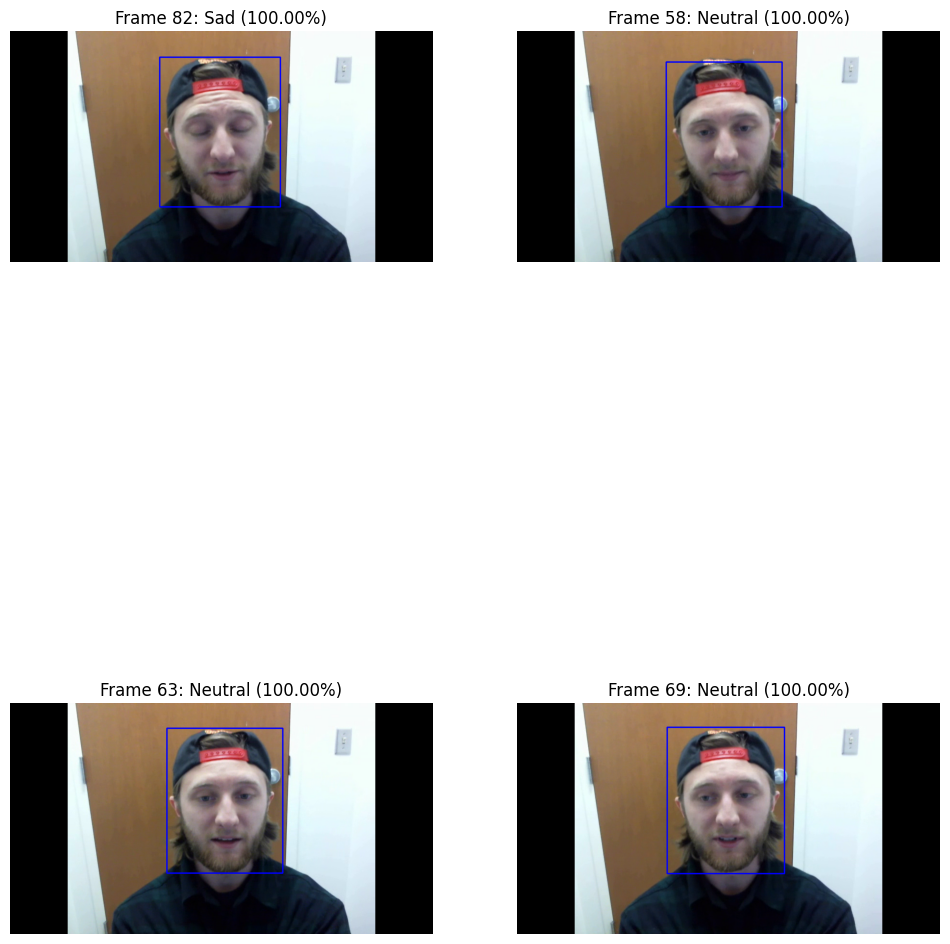

In [ ]:
from Inference import VIVIT_Classifier
X_train, X_test, y_train, y_test = train_test_split(test_dataloader, test_label, test_size=0.8, random_state=42)

X_sample = X_test[2].unsqueeze(0).float()
y_sample = y_test[2].float()
print('Input size: ',X_sample.shape)
print('Input size: ',y_sample.shape)

lie_detector = VIVIT_Classifier(model)
lie_detector.inference(X_sample, y_sample)
lie_detector.extract_attn_weights(n=4)

### Classification Interpretabiity
- Attentionn weight extraction
- Emotions analysis on 6 emotions: <br>
{0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"} <br>
Using pretrained model from source: https://github.com/Dipeshtamboli/emotion-detection-using-TF

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 10.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [ ]:
from torchmetrics.classification import BinaryConfusionMatrix
def confusion_matrix(X, y, model):
        sigmoid = nn.Sigmoid()
        model.eval()
        model.to(torch.device('cpu'))
        y_pred = torch.zeros(len(X))
        for i in range(len(X)):
          X_i = X[i].unsqueeze(0).float()
          output = model(X_i)
          output = sigmoid(output)
          y_pred[i] = output
        min = torch.min(y_pred)
        max = torch.max(y_pred)
        for i in range(len(y_pred)):
          print((y_pred[i] - min)/(max - min))
          if (y_pred[i] - min)/(max - min)>=0.5:
            y_pred[i] = 1
          else:
            y_pred[i] = 0
        bcm = BinaryConfusionMatrix()
        return bcm(y_pred, y.reshape(len(X)))

In [ ]:
confusion_matrix(test_dataloader, test_label, model)

tensor(0.6561, grad_fn=<DivBackward0>)
tensor(0.4966, grad_fn=<DivBackward0>)
tensor(0., grad_fn=<DivBackward0>)
tensor(0.4179, grad_fn=<DivBackward0>)
tensor(0.2800, grad_fn=<DivBackward0>)
tensor(0.7704, grad_fn=<DivBackward0>)
tensor(0.8730, grad_fn=<DivBackward0>)
tensor(1., grad_fn=<DivBackward0>)


tensor([[2, 2],
        [2, 2]])

In [ ]:
print(test_label)

tensor([[1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.]], dtype=torch.float64)


In [ ]:
%tb